In this iPython notebook, we will featurize MOR ligand binding simulation by pairwise distances between the ligand and different receptor residues. We will then perform tICA and prospectively build an MSM. 

In [1]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')
#matplotlib.rcParams["figure.facecolor"] = "white"
#matplotlib.rcPar|ams["savefig.transparent"] = "True"


In [2]:
import pandas as pd


from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
from grids import *
from docking_analysis import *

from scipy import stats
import os
from efficacy_scripts import *




/home/enf/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
from sklearn.preprocessing import scale

In [5]:
from detect_intermediates import *
from interpret_tICs import *

In [6]:
from msmbuilder.utils import verbosedump, verboseload


In [7]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import scale
from random import shuffle
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

In [8]:
def normalize_per_ligand(df):
    new_df = copy.deepcopy(df)
    n_df = new_df.ix[:, [i for i in range(0, new_df.shape[1]) if "difference" not in new_df.columns.values[i].lower()]]
    n_df = pd.DataFrame(preprocessing.scale(n_df.values, axis=1), index=n_df.index, columns=n_df.columns.values.tolist())
    new_df = pd.concat([new_df, n_df], axis=1)
    return(new_df)

In [9]:
import multiprocessing as mp
mp.cpu_count()

12

In [10]:
from ipyparallel import Client
rc = Client()
print(len(rc.ids))
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))

231


<AsyncMapResult: chdir>

In [10]:
agonist_df_file = "/home/enf/md_simulations/MOR/docking/full_agonist_df.pkl"
with open(agonist_df_file, "rb") as f:
    full_ligand_df = pickle.load(f)

In [11]:
agonist_df_file = "/home/enf/md_simulations/MOR/docking/curated_agonist_df.pkl"
with open(agonist_df_file, "rb") as f:
    full_ligand_df = pickle.load(f)

In [12]:
import pybel

fps = []
for x in full_ligand_df.smiles:
    try:
        mol = pybel.readstring("smi", x)
        fps.append(mol.calcfp(fptype='FP4'))
    except:
        fps.append(None)

full_ligand_df["fp"] = fps

In [13]:
#import grids
#reload(grids)
from grids import *

precision = "SP"

ref_receptors_dir = "/home/enf/md_simulations/MOR/bu72_ref_receptors/conformation"
active_ref_dir = "%s/bu72_ionized_pymol_RL_conformation.pdb" %ref_receptors_dir
inactive_ref_dir = "%s/bu72_aligned_4DKL_R_L_conformation.pdb" %ref_receptors_dir

analysis_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components2all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_2_regularization_wolf_autoShrinkage0pt01-backup/analysis_n_clusters25_random"
base_docking_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/docking_100clusters"
ligands_dir = "/home/enf/md_simulations/MOR/docking/ligands/32-stereoisomers_6-ring-conf"
grid_dir = "%s/grids" %base_docking_dir
docking_dir = "%s/docking_%s" %(base_docking_dir, precision)
docking_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components2all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_2_regularization_wolf_autoShrinkage0pt01-backup/all_clusterer_25clusters_1samples_samples_kdtree/docking_SP_32-stereoisomers_6-ring-conf"
#docking_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components2all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_2_regularization_wolf_autoShrinkage0pt01-backup/all_clusterer_25clusters_1samples_samples_kdtree/docking_XP"

In [14]:
%load_ext autoreload
%autoreload 2

In [15]:
import analysis
from importlib import reload
reload(analysis)
from analysis import *

docking_df, poses_df = analyze_docking_results_multiple(docking_dir, precision, "%s/summary.pkl" %docking_dir, 
ligands=[n for n in get_ligands(ligands_dir, ".mae") if "_" != n[0]], poses_summary=None, redo=False, reread=False,
write_to_disk=True, worker_pool=None, parallel=True)

#docking_df, poses_df = analyze_docking_results_in_dir(docking_dir, ligands_dir, write_to_disk=True, redo=True)
docking_df[docking_df.columns] = np.nan_to_num(docking_df[docking_df.columns].values)
zeros_per_row = (docking_df == 0).sum(axis=1)
docking_df = docking_df.loc[zeros_per_row < 5]
#where_zeros = np.where(docking_df.values == 0)
#for row_index in where

#keep_cols = []
#for drug in docking_df.index:
#    if np.where(docking_df.loc[column].values == 0).shape[0] < 3:
#        keep_cols.append(col)
#docking_df = docking_df[keep_cols]


In [16]:
full_docking_df = copy.deepcopy(docking_df)
#full_docking_df = pd.concat([ref_df, docking_df[[c for c in docking_df.columns.values.tolist() if "cluster" in c]]], axis=1)
full_docking_df[full_docking_df.columns] = np.nan_to_num(full_docking_df[full_docking_df.columns].values)
new_names =  [n.replace("cluster", "State ").replace("_sample0", "") for n in full_docking_df.columns.values.tolist()]
new_names = ["Inactive Crystal", "Active Crystal"] + new_names[2:]
full_docking_df.columns = new_names
full_docking_df.index = [n.lower().strip().replace(" ", "_").replace("β", "beta").replace("α", "alpha").replace("Α", "alpha") for n in full_docking_df.index.values]
full_docking_df = full_docking_df.groupby(full_docking_df.index).first()

In [17]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)

In [18]:
common_ligands = [n for n in full_ligand_df.drop_duplicates().index.values if n.lower().strip() in full_docking_df.index.values]
print(len(common_ligands))

229


In [19]:
full_ligand_df.drop_duplicates().shape

(248, 12)

In [61]:
def add_difference_columns(df):
    new_df = copy.deepcopy(df)
    for i, col_i in enumerate(df.columns):
        print(i)
        for j, col_j in enumerate(df.columns):
           if j <= i: continue
    ##        if "crystal" in col_j.lower() or "crystal" in col_i.lower(): continue
           new_df["%s-%s" %(col_j, col_i)] = new_df[col_j].subtract(new_df[col_i])
    for i, col_i in enumerate(df.columns):
        if col_i != "Active Crystal":
            new_df["Active Crystal-%s" %col_i] = new_df["Active Crystal"].subtract(new_df[col_i])
    return(new_df)

In [21]:
results_dict = {}

In [58]:
import efficacy_scripts
reload(efficacy_scripts)
from efficacy_scripts import *

X_df = full_docking_df
X_df = add_difference_columns(X_df)
#X_df["difference"] = X_df["Active Crystal"].subtract(X_df["Inactive Crystal"]).dropna()
C_df = X_df[[n for n in X_df.columns.values.tolist() if "State" not in n]]

ligand_df = copy.deepcopy(full_ligand_df[[c for c in full_ligand_df.columns.values if "fp" not in c.lower()]]).drop_duplicates(subset=['name'], keep='first')
ligand_df = ligand_df.loc[[n for n in ligand_df.index.values if n in full_docking_df.index.values]]
ligand_df.index = [n.lower() for n in ligand_df.index.values]
ligand_df = ligand_df.loc[ligand_df.smiles.dropna().index]
mols = [pybel.readstring("smi", x) for x in ligand_df.smiles]
fps = [x.calcfp(fptype='FP4') for x in mols] # Calculate their fingerprints
ligand_df["fp"] = fps


classes = ligand_df["action"].values.tolist()
class_labels = []
indices = []
n_antagonists = 0
n_agonists = 0
for i, label in enumerate(classes):
        if "antagonist" == label.lower():# or "neutral" in label.lower() or "negative" in label.lower():
                class_labels.append(0.)
                indices.append(i)
                n_antagonists += 1
        elif "agonist" == label.lower():# or "positive" in label.lower():
                class_labels.append(1.)
                indices.append(i)
                n_agonists += 1

print("n_antagonists: %d" %n_antagonists)
print("n_agonists: %d" %n_agonists)

ligand_df = ligand_df.iloc[indices]
ligand_df["label"] = class_labels

mols = [pybel.readstring("smi", x) for x in ligand_df.smiles]
fps = [x.calcfp(fptype='FP4') for x in mols] # Calculate their fingerprints
ligand_df["fp"] = fps

similarity_matrix = np.zeros((len(mols), len(mols)))
remove_ligands = []
print("original ligands: %d" %ligand_df.shape[0])

for i in range(0, len(mols)):
    for j in range(i, len(mols)):
        if i == j:
            continue            
        similarity_matrix[i][j] = fps[i] | fps[j]
        if similarity_matrix[i][j] > 1.:
            remove_ligands.append(j)
            #continue

print(len(remove_ligands))
ligand_df = ligand_df.iloc[[i for i in range(0, len(mols)) if i not in remove_ligands]]

model_agonists = [n for n in ligand_df.index.values]

y = ligand_df["label"].values.reshape((-1,1))
y_df = pd.DataFrame(y, index=ligand_df.index)

n_trials = 20
train_test_split_prop = 0.9
model_type = "rfr"

normalize = False
normalize_axis0 = False
if normalize_axis0:
    double_features = 2
    X_df = normalize_per_ligand(X_df)

else: 
    double_features = 1
n_estimators = 1000

methadone_ligands = [n for n in model_agonists if "fent" in n]
print(methadone_ligands)
base_ligand = "fentanyl"
#methadone_ligands = [n for n in model_agonists if base_ligand in n.lower()]
print(methadone_ligands)
tanimoto_cutoff = 0.7
methadone_ligands = [n for n in model_agonists if n in methadone_ligands or (ligand_df.loc[n]["fp"] | ligand_df.loc[base_ligand]["fp"]) > tanimoto_cutoff]

methadone_agonists = [n for n in ligand_df.loc[ligand_df.label == 1.].index.values.tolist() if n in methadone_ligands]
antagonists = [n for n in ligand_df.loc[ligand_df.label == 0.].index.values.tolist() if n not in methadone_ligands and (ligand_df.loc[n]["fp"] | ligand_df.loc["methadone"]["fp"]) < (tanimoto_cutoff-.2)]
other_agonists = [n for n in ligand_df.loc[ligand_df.label == 1.].index.values.tolist() if n not in methadone_ligands and (ligand_df.loc[n]["fp"] | ligand_df.loc["methadone"]["fp"]) < (tanimoto_cutoff-.2)]

#random.shuffle(antagonists)
#model_agonists = other_agonists + antagonists[:int(len (antagonists)*3/4)]
#y_df = y_df.loc[model_agonists]
#y = y_df.values


features = [C_df.loc[model_agonists], X_df.loc[model_agonists]]#, all_features_df]#, all_features]
feature_names = ["Crystal Structures", "MSM Docking"]
print([f.shape for f in features])

#methadone_ligands = [n.lower().strip().replace(" ", "_") for n in ["18-Methoxycoronaridine", "7-Acetoxymitragynine", "7-Hydroxymitragynine", "Akuammidine","Akuammine", "Coronaridine", "Eseroline", "Hodgkinsine", "Ibogaine", "Mitragynine", "Mitragynine pseudoindoxyl", "Noribogaine", "Pericine", "Pseudoakuammigine"] if n.lower().strip().replace(" ", "_") in model_agonists]


c_log_aucs = []
c_aucs = []

m_log_aucs = []
m_aucs = []

import random

names = ligand_df.index.values.tolist()
antagonist_inds = [names.index(n) for n in antagonists]
non_methadone_agonist_inds = [names.index(n) for n in other_agonists]
methadone_inds = [names.index(n) for n in methadone_agonists]

splitter = CustomSplitter(antagonist_inds,
                          non_methadone_agonist_inds,
                          methadone_inds)


n_trials = 20
save_name = "two_class_nomethadone_%s_trials%d_tanimoto%s" %(model_type, n_trials, str(tanimoto_cutoff))
results_dict[save_name] = generate_or_load_model([f.values for f in features], y, feature_names, n_trials, train_test_split_prop, False, model_type, 
                                                 "%s/%s.pkl" %(analysis_dir, save_name),redo=True, worker_pool=None,
                                                 parallel=True, n_estimators=n_estimators, max_depth=None, criterion='gini',
                                                 normalize=False, splitter=splitter, normalize_axis0=False)




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
n_antagonists: 47
n_agonists: 197
original ligands: 244
0
['acetylfentanyl', 'acrylfentanyl', 'alfentanil', '3-allylfentanyl', 'alphamethylthiofentanyl', 'betahydroxyfentanyl', 'brifentanil', 'butyrfentanyl', 'carfentanil', 'fentanyl', '4-fluorobutyrfentanyl', 'furanylfentanyl', '4-methoxybutyrfentanyl', 'alpha-methylacetylfentanyl', '3-methylbutyrfentanyl', 'n-methylcarfentanil', '3-methylfentanyl', 'beta-methylfentanyl', '3-methylthiofentanyl', 'mirfentanil', 'ocfentanil', 'ohmefentanyl', 'parafluorofentanyl', '4-phenylfentanyl', 'remifentanil', 'sufentanil', 'thiofentanyl']
['acetylfentanyl', 'acrylfentanyl', 'alfentanil', '3-allylfentanyl', 'alphamethylthiofentanyl', 'betahydroxyfentanyl', 'brifentanil', 'butyrfentanyl', 'carfentanil', 'fentanyl', '4-fluorobutyrfentanyl', 'furanylfentanyl', '4-methoxybutyrfentanyl', 'alpha-methylacetylfentanyl', '3-methylbutyrfentanyl', 'n-methylcarfentanil', '3-methylfentanyl',

analyzing precision at full recall:
(20, 2)
                    Median AUC  Median delta AUC       Sign Test 99% CI
Crystal Structures    0.821469            0.0000               (0, 0.0)
MSM Docking           0.909369            0.0879  (0.750894598901, 1.0)


ValueError: list.remove(x): x not in list

analyzing threshold at full recall:
(20, 2)
                    Median AUC  Median delta AUC       Sign Test 99% CI
Crystal Structures     0.32500           0.00000               (0, 0.0)
MSM Docking            0.69315           0.36815  (0.750894598901, 1.0)


ValueError: list.remove(x): x not in list

analyzing Accuracy:
(20, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.809184          0.000000   
MSM Docking           0.800000         -0.009184   

                                    Sign Test 99% CI  
Crystal Structures                          (0, 0.0)  
MSM Docking         (0.146393441377, 0.628338178953)  


ValueError: list.remove(x): x not in list

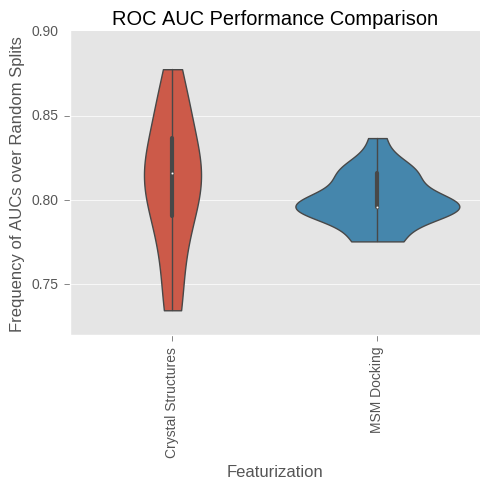

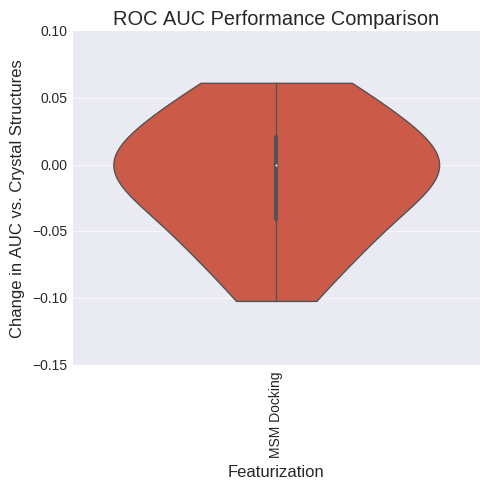

analyzing Recall:
(20, 2)
                    Median AUC  Median delta AUC       Sign Test 99% CI
Crystal Structures    0.922368          0.000000               (0, 0.0)
MSM Docking           1.000000          0.077632  (0.750894598901, 1.0)


ValueError: list.remove(x): x not in list

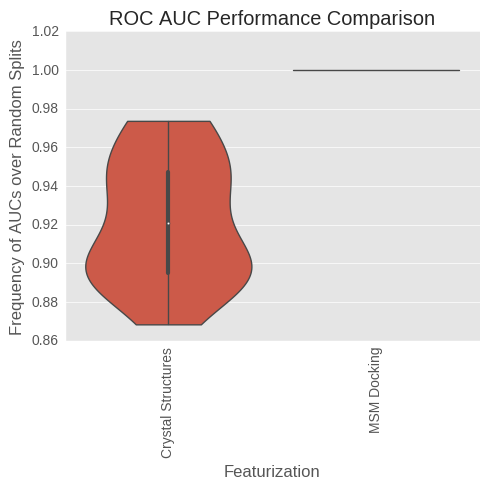

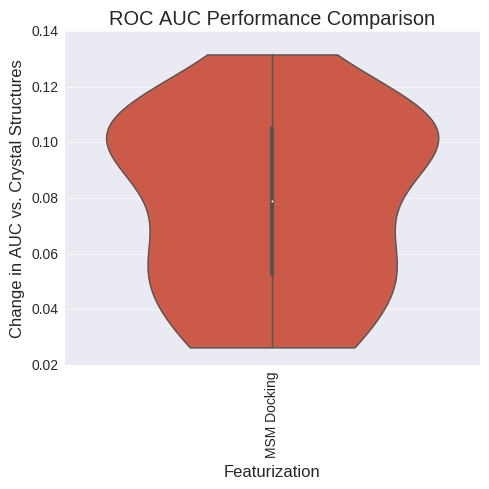

analyzing precision:
(20, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.846676          0.000000   
MSM Docking           0.795175         -0.051501   

                                     Sign Test 99% CI  
Crystal Structures                           (0, 0.0)  
MSM Docking         (0.0197865343503, 0.379497786529)  


ValueError: list.remove(x): x not in list

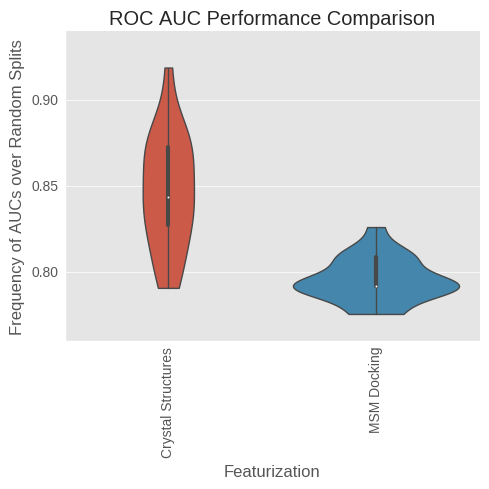

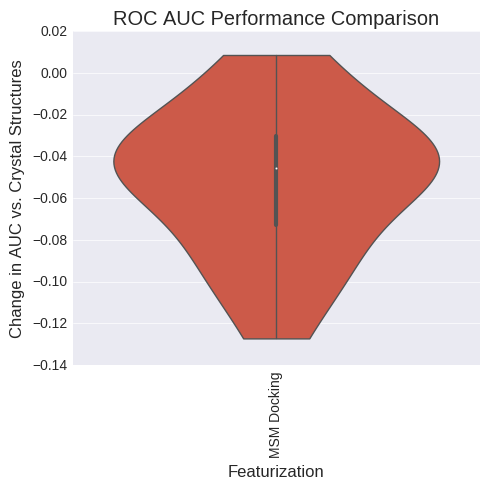

analyzing fdr:
(20, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.153324          0.000000   
MSM Docking           0.204825          0.051501   

                                   Sign Test 99% CI  
Crystal Structures                         (0, 0.0)  
MSM Docking         (0.620502213471, 0.98021346565)  


ValueError: list.remove(x): x not in list

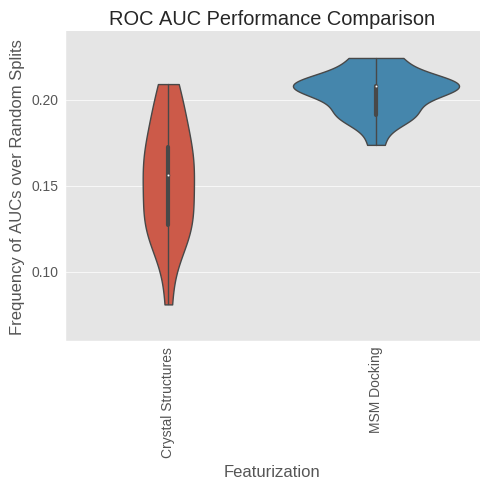

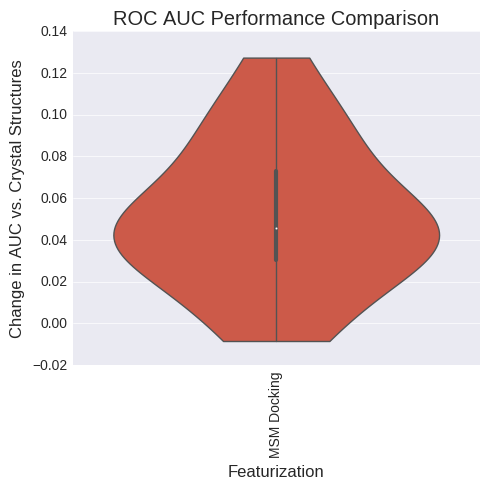

analyzing Recall:
(20, 2)
                    Median AUC  Median delta AUC       Sign Test 99% CI
Crystal Structures    0.922368          0.000000               (0, 0.0)
MSM Docking           1.000000          0.077632  (0.750894598901, 1.0)


ValueError: list.remove(x): x not in list

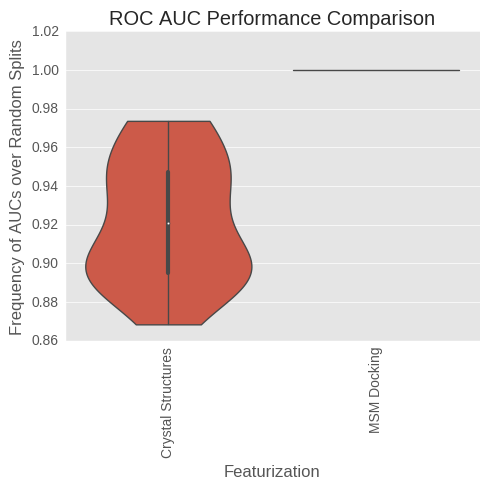

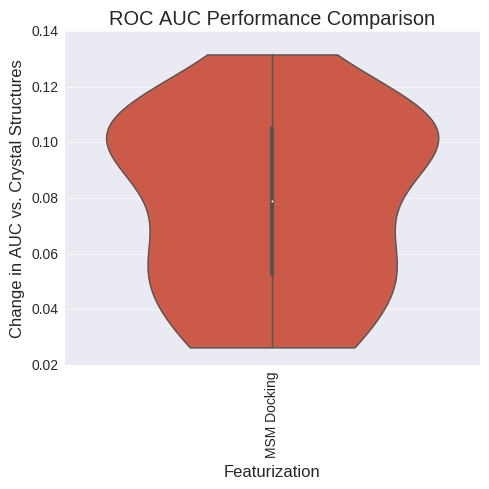

analyzing precision:
(20, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.846676          0.000000   
MSM Docking           0.795175         -0.051501   

                                     Sign Test 99% CI  
Crystal Structures                           (0, 0.0)  
MSM Docking         (0.0197865343503, 0.379497786529)  


ValueError: list.remove(x): x not in list

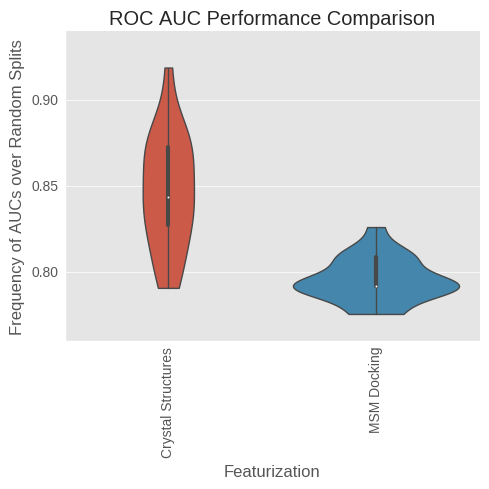

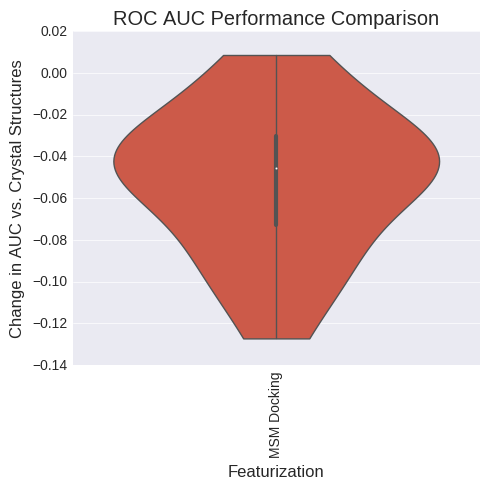

analyzing fdr:
(20, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.153324          0.000000   
MSM Docking           0.204825          0.051501   

                                   Sign Test 99% CI  
Crystal Structures                         (0, 0.0)  
MSM Docking         (0.620502213471, 0.98021346565)  


ValueError: list.remove(x): x not in list

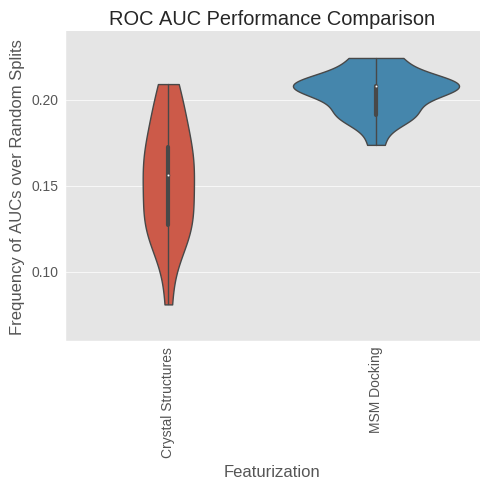

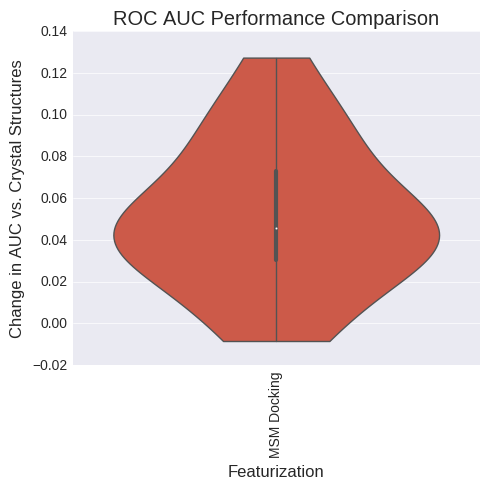

analyzing class B ROC AUC:
(20, 2)
                    Median AUC  Median delta AUC       Sign Test 99% CI
Crystal Structures    0.738756          0.000000               (0, 0.0)
MSM Docking           0.944199          0.205443  (0.750894598901, 1.0)


ValueError: list.remove(x): x not in list

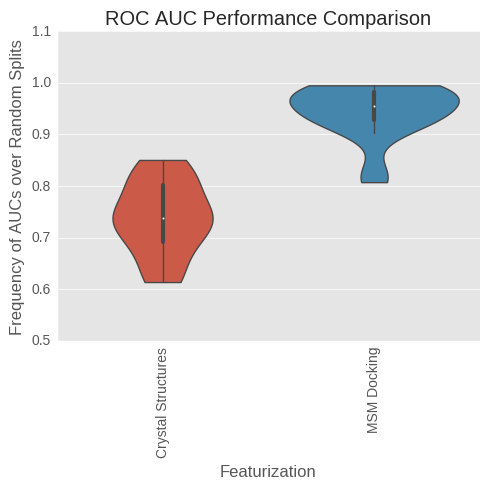

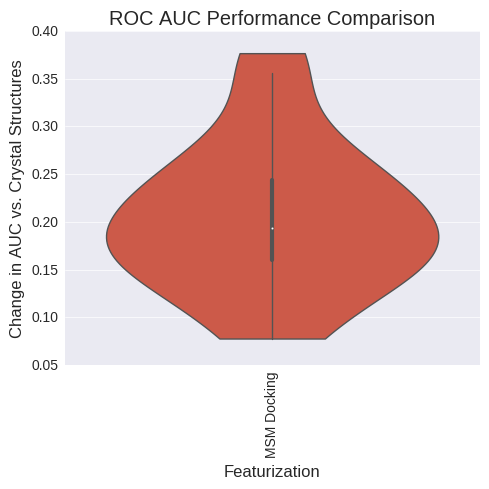

analyzing ROC AUC:
(20, 2)
                    Median AUC  Median delta AUC       Sign Test 99% CI
Crystal Structures    0.738756          0.000000               (0, 0.0)
MSM Docking           0.944199          0.205443  (0.750894598901, 1.0)


ValueError: list.remove(x): x not in list

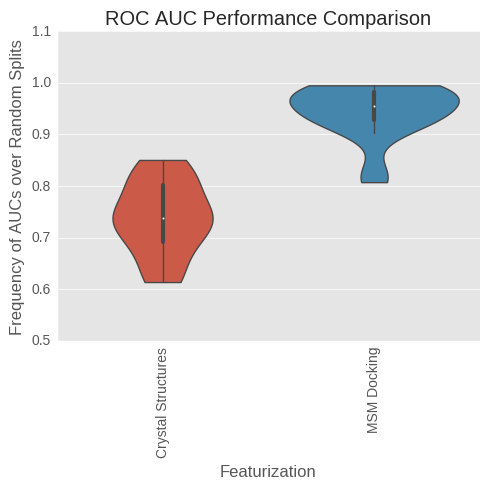

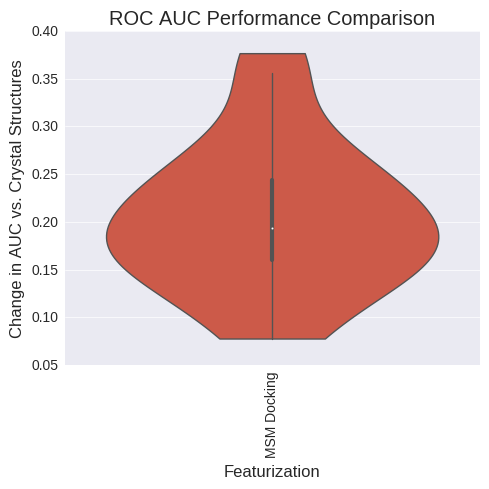

analyzing BedROC
(20, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.878078          0.000000   
MSM Docking           0.998329          0.120251   

                                   Sign Test 99% CI  
Crystal Structures                         (0, 0.0)  
MSM Docking         (0.620502213471, 0.98021346565)  


ValueError: list.remove(x): x not in list

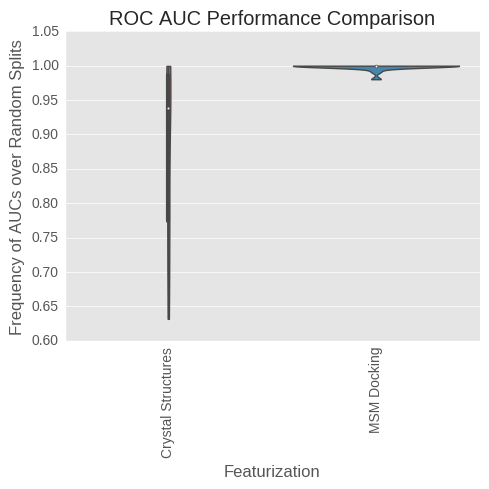

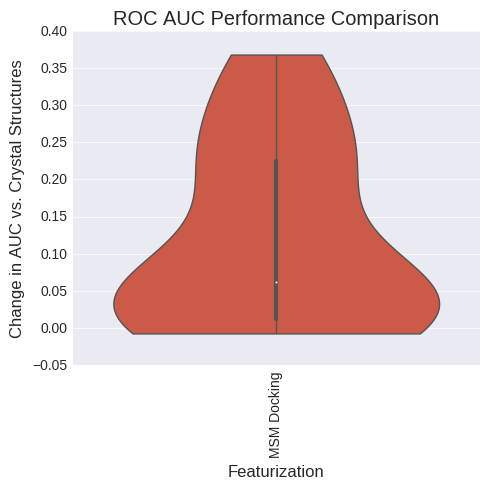

analyzing LogAUC
(20, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.220382          0.000000   
MSM Docking           0.293338          0.072956   

                                    Sign Test 99% CI  
Crystal Structures                          (0, 0.0)  
MSM Docking         (0.564413279739, 0.961212939492)  


ValueError: list.remove(x): x not in list

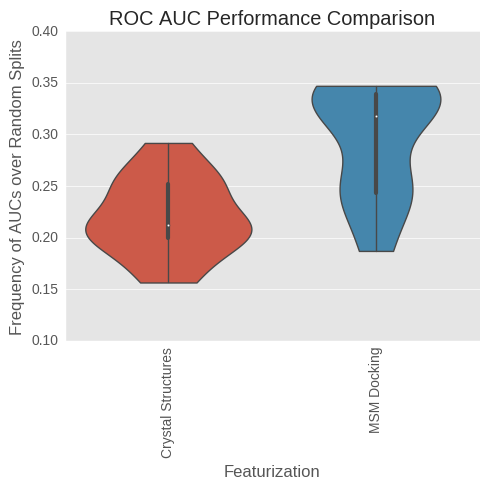

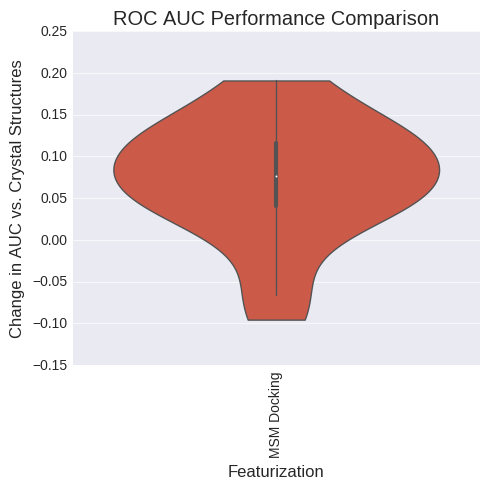

(3,)
(1, 3)


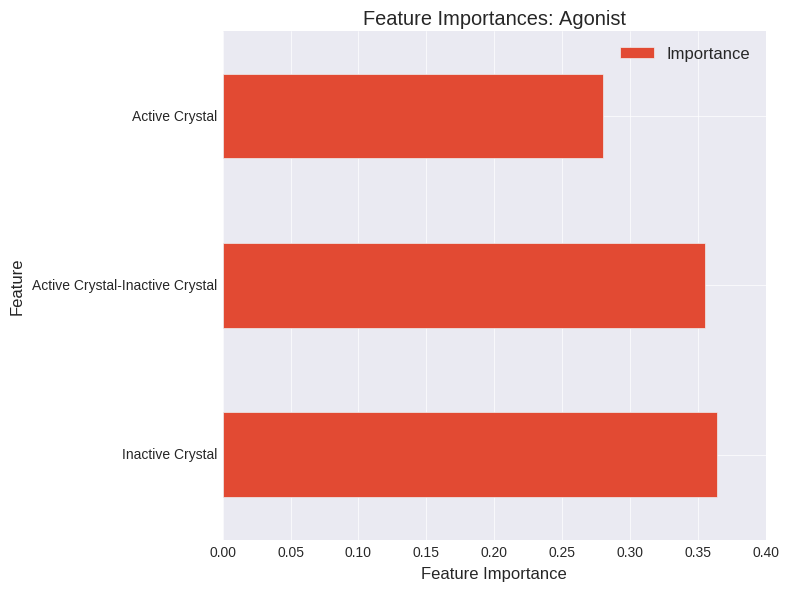

(403,)
(1, 403)


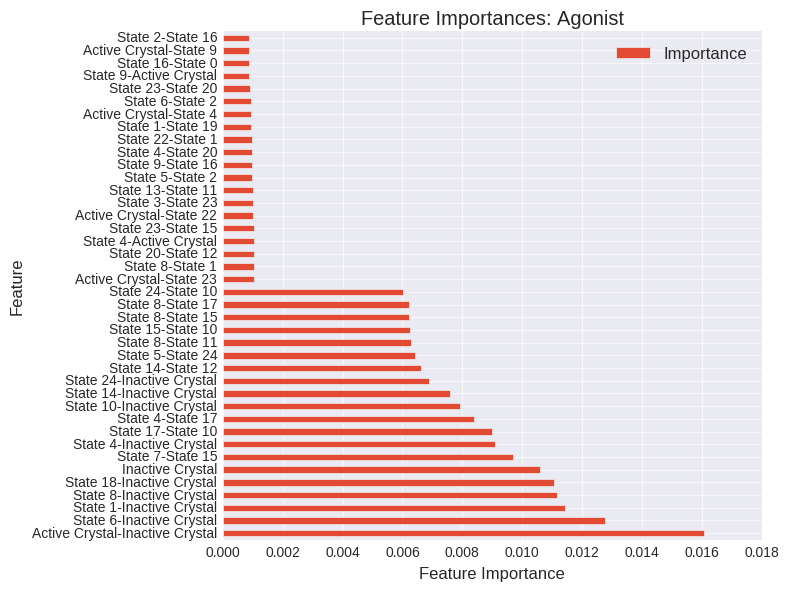

In [60]:
#Normalize False, axis0 True, RFR; fentanyl split
importance_dfs = analyze_multiclass_experiment(results_dict[save_name], 
                                                                feature_names,
                                                                [f.columns.values.tolist() for f in features], ligand_df.index.values, analysis_dir,
                                                                ["Antagonist", "Agonist"], 
                                                                #["Gs Inactive", "Gs Active"], 
                                                               #["Arr Inactive", "Arr Active"],
                                               np.hstack([X_df.iloc[indices].values]),
                                                               #["Gs Inactive", "Gs Partial Active", "Gs Full Active"], 
                                              remake=False, fxn=np.mean)

In [54]:
full_ligand_df.loc[full_ligand_df.smiles.dropna().index]

,Edits,Unnamed: 0,Unnamed: 4,Unnamed: 5,Unnamed: 7,action,assay,ligand,name,smiles,source,fp
name,,,,,,,,,,,,
7-pet,Agonist,1.0,NaN,NaN,NaN,agonist,NaN,7-pet,7-pet,C[C@@](CCC1=CC=CC=C1)([C@H]2C[C@@]34C=C[C@@]2([C@H]5[C@@]36CCN([C@@H]4CC7=C6C(=C(C=C7)OC)O5)C)OC)O,wikipedia,"37931039, 0, 0, 0, 0, 0, 0, 0, 6684672, 270403, 0, 0, 0, 0, 0, 0"
acetorphine,"may not bind the receptor, prodrug likely",2.0,NaN,NaN,NaN,agonist,NaN,acetorphine,acetorphine,CCC[C@](C)([C@H]1CC23C=CC1([C@@H]4C25CCN(C3CC6=C5C(=C(C=C6)OC(=O)C)O4)C)OC)O,wikipedia,"37931039, 0, 9437184, 0, 0, 0, 0, 0, 6684672, 337987, 0, 0, 0, 0, 0, 0"
acetyldihydrocodeine,"may not bind the receptor, prodrug likely",4.0,NaN,NaN,NaN,agonist,NaN,acetyldihydrocodeine,acetyldihydrocodeine,CC(=O)O[C@H]1CC[C@H]2[C@H]3CC4=C5[C@]2([C@H]1OC5=C(C=C4)OC)CCN3C,wikipedia,"37879823, 0, 9437184, 0, 0, 0, 0, 0, 6684672, 337984, 0, 0, 0, 0, 0, 0"
acetylfentanyl,agonist,5.0,NaN,NaN,NaN,agonist,NaN,acetylfentanyl,acetylfentanyl,CC(=O)N(C1CCN(CC1)CCC2=CC=CC=C2)C3=CC=CC=C3,wikipedia,"37748739, 0, 8388608, 18, 0, 0, 0, 0, 393216, 75840, 0, 0, 0, 0, 0, 0"
acetylmethadol,agonist,6.0,NaN,NaN,NaN,agonist,NaN,acetylmethadol,acetylmethadol,CCC(C(CC(C)N(C)C)(C1=CC=CC=C1)C2=CC=CC=C2)OC(=O)C,wikipedia,"37748747, 0, 9437184, 0, 0, 0, 0, 0, 131072, 75840, 0, 0, 0, 0, 0, 0"
acetylpropionylmorphine,"may not bind the receptor, prodrug likely",8.0,NaN,NaN,NaN,agonist,NaN,acetylpropionylmorphine,acetylpropionylmorphine,CCC(=O)OC1C=CC2C3CC4=C5C2(C1OC5=C(C=C4)OC(=O)C)CCN3C,wikipedia,"37879839, 0, 9437184, 0, 0, 0, 0, 0, 6684672, 75843, 0, 0, 0, 0, 0, 0"
acrylfentanyl,agonist,9.0,NaN,NaN,NaN,agonist,NaN,acrylfentanyl,acrylfentanyl,C=CC(=O)N(C1CCN(CC1)CCC2=CC=CC=C2)C3=CC=CC=C3,wikipedia,"37748754, 0, 8388608, 18, 0, 0, 0, 0, 1074135040, 26688, 0, 0, 0, 0, 0, 0"
ad-1211,maybe mixed agonist-antagonist- safe to assume its partial,10.0,NaN,NaN,NaN,agonist,NaN,ad-1211,ad-1211,CC(=CCN1CCN(CC1)C(CC2=CC(=CC=C2)O)C3=CC=CC=C3)C,wikipedia,"37748755, 0, 0, 0, 0, 256, 0, 0, 393216, 8256, 0, 0, 0, 0, 0, 0"
adrenorphin,agonist,11.0,NaN,NaN,NaN,agonist,NaN,adrenorphin,adrenorphin,CC(C)[C@@H](C(=O)N)NC(=O)[C@@H](CCCN=C(N)N)NC(=O)[C@H](CCCN=C(N)N)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)CNC(=O)CNC(=O)[C@H](CC2=CC=C(C=C2)O)N,wikipedia,"12648455, 16, 8388608, 1073741838, 4210689, 256, 0, 0, 131072, 272448, 0, 0, 0, 0, 0, 0"


In [ ]:
test_ligands = methadone_agonists+antagonists[int(len(antagonists)*3/4):]
test_df = pd.DataFrame(results_dict[save_name]["MSM Docking"][0].predict_proba(X_df), index=X_df.index, columns=["antagonist", "agonist"])
test_df["class"] = ligand_df.loc[test_ligands]["label"]
print(roc_auc_score(ligand_df.loc[test_ligands]["label"].values.reshape((-1,1)), test_df.loc[test_ligands].values[:,1]))
test_df.loc[[n for n in test_df.index if n in test_ligands]].sort("antagonist", ascending=False, inplace=False)

In [ ]:
test_ligands = methadone_agonists+antagonists[int(len(antagonists)*3/4):]
test_df = pd.DataFrame(results_dict[save_name]["Crystal Structures"][0].predict_proba(C_df), index=X_df.index, columns=["antagonist", "agonist"])
test_df["class"] = ligand_df.loc[test_ligands]["label"]
print(roc_auc_score(ligand_df.loc[test_ligands]["label"].values.reshape((-1,1)), test_df.loc[test_ligands].values[:,1]))
test_df.loc[[n for n in test_df.index if n in test_ligands]].sort("antagonist", ascending=False, inplace=False)

In [ ]:
import efficacy_scripts
reload(efficacy_scripts)
from efficacy_scripts import *

X_df = full_docking_df
#X_df["difference"] = X_df["Active Crystal"].subtract(X_df["Inactive Crystal"]).dropna()
C_df = X_df[[n for n in X_df.columns.values.tolist() if "State" not in n]]

ligand_df = copy.deepcopy(full_ligand_df[[c for c in full_ligand_df.columns.values if "fp" not in c.lower()]]).drop_duplicates(subset=['name'], keep='first')
ligand_df = ligand_df.loc[[n for n in ligand_df.index.values if n in full_docking_df.index.values]]
ligand_df.index = [n.lower() for n in ligand_df.index.values]

mols = [pybel.readstring("smi", x) for x in ligand_df.smiles]
fps = [x.calcfp(fptype='FP4') for x in mols] # Calculate their fingerprints
ligand_df["fp"] = fps

classes = ligand_df["action"].values.tolist()
class_labels = []
indices = []
n_antagonists = 0
n_agonists = 0
for i, label in enumerate(classes):
        if "antagonist" == label.lower():# or "neutral" in label.lower() or "negative" in label.lower():
                class_labels.append(0.)
                indices.append(i)
                n_antagonists += 1
        elif "agonist" == label.lower():# or "positive" in label.lower():
                class_labels.append(1.)
                indices.append(i)
                n_agonists += 1

print("n_antagonists: %d" %n_antagonists)
print("n_agonists: %d" %n_agonists)

ligand_df = ligand_df.iloc[indices]
ligand_df["label"] = class_labels

model_agonists = [n for n in ligand_df.index.values]

y = ligand_df["label"].values.reshape((-1,1))
y_df = pd.DataFrame(y, index=ligand_df.index)

n_trials = 100
train_test_split_prop = 0.9
model_type = "rfr"

normalize = False
normalize_axis0 = True
if normalize_axis0:
    double_features = 2
    X_df = normalize_per_ligand(X_df)

else: 
    double_features = 1
n_estimators = 1000

features = [C_df.loc[model_agonists], X_df.loc[model_agonists]]#, all_features_df]#, all_features]
feature_names = ["Crystal Structures", "MSM Docking"]
print([f.shape for f in features])

#methadone_ligands = [n.lower().strip().replace(" ", "_") for n in ["18-Methoxycoronaridine", "7-Acetoxymitragynine", "7-Hydroxymitragynine", "Akuammidine","Akuammine", "Coronaridine", "Eseroline", "Hodgkinsine", "Ibogaine", "Mitragynine", "Mitragynine pseudoindoxyl", "Noribogaine", "Pericine", "Pseudoakuammigine"] if n.lower().strip().replace(" ", "_") in model_agonists]
methadone_ligands = [n for n in model_agonists if "methad" in n]
print(methadone_ligands)
base_ligand = "methadone"
#methadone_ligands = [n for n in model_agonists if base_ligand in n.lower()]
print(methadone_ligands)
tanimoto_cutoff = 0.7
methadone_ligands = [n for n in model_agonists if n in methadone_ligands or (ligand_df.loc[n]["fp"] | ligand_df.loc[base_ligand]["fp"]) > tanimoto_cutoff]

methadone_agonists = [n for n in ligand_df.loc[ligand_df.label == 1.].index.values.tolist() if n in methadone_ligands]
antagonists = [n for n in ligand_df.loc[ligand_df.label == 0.].index.values.tolist() if n not in methadone_ligands and (ligand_df.loc[n]["fp"] | ligand_df.loc["methadone"]["fp"]) < (tanimoto_cutoff-.2)]
other_agonists = [n for n in ligand_df.loc[ligand_df.label == 1.].index.values.tolist() if n not in methadone_ligands and (ligand_df.loc[n]["fp"] | ligand_df.loc["methadone"]["fp"]) < (tanimoto_cutoff-.2)]


c_log_aucs = []
c_aucs = []

m_log_aucs = []
m_aucs = []

import random

names = ligand_df.index.values.tolist()
antagonist_inds = [names.index(n) for n in antagonists]
non_methadone_agonist_inds = [names.index(n) for n in other_agonists]
methadone_inds = [names.index(n) for n in methadone_agonists]

splitter = CustomSplitter(antagonist_inds,
                          non_methadone_agonist_inds,
                          methadone_inds)


save_name = "two_class_nomethadone_%s_trials%d_tanimoto%s" %(model_type, n_trials, str(tanimoto_cutoff))
results_dict[save_name] = generate_or_load_model([f.values for f in features], y, feature_names, n_trials, train_test_split_prop, False, model_type, 
                                                 "%s/%s.pkl" %(analysis_dir, save_name),redo=False, worker_pool=dview,
                                                 parallel=False, n_estimators=1000, max_depth=None, criterion='gini',
                                                 normalize=False, splitter=splitter, normalize_axis0=False)



In [ ]:
#Normalize False, axis0 True, RFR, methadone, 0.7, 0.5



importance_dfs = analyze_multiclass_experiment(results_dict[save_name], 
                                                                feature_names,
                                                                [f.columns.values.tolist() for f in features], model_agonists, analysis_dir,
                                                                ["Antagonist", "Agonist"], 
                                                                #["Gs Inactive", "Gs Active"], 
                                                               #["Arr Inactive", "Arr Active"],
                                               np.hstack([X_df.iloc[indices].values]),
                                                               #["Gs Inactive", "Gs Partial Active", "Gs Full Active"], 
                                              remake=False, fxn=np.median)

In [ ]:
fent_ligands = ["18-Methoxycoronaridine", "7-Acetoxymitragynine", "7-Hydroxymitragynine", "Akuammidine","Akuammine", "Coronaridine", "Eseroline", "Hodgkinsine", "Ibogaine", "Mitragynine", "Mitragynine pseudoindoxyl", "Noribogaine", "Pericine", "Pseudoakuammigine"]
fent_ligands = [n for n in ligand_df.index.values.tolist() if n in fent_ligands or (new_ligand_df.loc[n]["fp"] | new_ligand_df.loc["Eseroline"]["fp"]) > .8]
antagonists = [n for n in ligand_df.loc[ligand_df.label == 0.].index.values.tolist() if n not in fent_ligands]
other_agonists = [n for n in ligand_df.loc[ligand_df.label == 1.].index.values.tolist() if n not in fent_ligands and (new_ligand_df.loc[n]["fp"] | new_ligand_df.loc["Eseroline"]["fp"]) < .6]

In [ ]:
fent_ligands = ["18-Methoxycoronaridine", "7-Acetoxymitragynine", "7-Hydroxymitragynine", "Akuammidine","Akuammine", "Coronaridine", "Eseroline", "Hodgkinsine", "Ibogaine", "Mitragynine", "Mitragynine pseudoindoxyl", "Noribogaine", "Pericine", "Pseudoakuammigine"]
fent_ligands = [n for n in ligand_df.index.values.tolist() if n in fent_ligands or (new_ligand_df.loc[n]["fp"] | new_ligand_df.loc["Eseroline"]["fp"]) > .8]

fent_agonists = [n for n in ligand_df.loc[ligand_df.label == 1.].index.values.tolist() if n in fent_ligands]
antagonists = [n for n in ligand_df.loc[ligand_df.label == 0.].index.values.tolist() if n not in fent_ligands]
other_agonists = [n for n in ligand_df.loc[ligand_df.label == 1.].index.values.tolist() if n not in fent_ligands and (new_ligand_df.loc[n]["fp"] | new_ligand_df.loc["Eseroline"]["fp"]) < .5]

In [ ]:
fent_ligands = [n for n in ligand_df.index.values.tolist() if "fent" in n.lower()]# or (new_ligand_df.loc[n]["fp"] | new_ligand_df.loc["Fentanyl"]["fp"]) > .7]
fent_ligands = [n for n in ligand_df.index.values.tolist() if "fent" in n.lower() or (new_ligand_df.loc[n]["fp"] | new_ligand_df.loc["Fentanyl"]["fp"]) > .6]
len(fent_ligands)


In [79]:
X_df = copy.deepcopy(full_docking_df)
X_df = X_df.dropna().reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
#X_df["Active Crystal-Inactive Crystal"] = X_df["Active Crystal"].subtract(X_df["Inactive Crystal"])
D_df = add_difference_columns(X_df)
#X_df = X_df[[n for n in X_df.columns if "difference" not in n]]
C_df = D_df[[n for n in D_df.columns.values.tolist() if "State" not in n]]

if not os.path.exists("%s/x_df.pkl" %analysis_dir):
    with open("%s/x_df.pkl" %analysis_dir, "wb") as f:
        pickle.dump(X_df, f, protocol=2)

ligand_df = copy.deepcopy(full_ligand_df[[c for c in full_ligand_df.columns.values if "fp" not in c.lower()]]).drop_duplicates(subset=['name'], keep='first')
ligand_df["label"] = 0.
ligand_df["label"].loc[ligand_df.action == "agonist"] = 1.
ligand_df = ligand_df.loc[ligand_df.assay != "AID_274396"]
ligand_df.index = [n.lower() for n in ligand_df.index.values]
ligand_df = ligand_df.loc[ligand_df.smiles.dropna().index]
print(full_ligand_df.shape)
print(ligand_df.shape)

ligand_df = ligand_df.loc[[n for n in ligand_df.index.values if n in full_docking_df.index.values]]
ligand_df = ligand_df.groupby(ligand_df.index).first()

mols = [pybel.readstring("smi", x) for x in ligand_df.smiles]
fps = [x.calcfp(fptype='FP4') for x in mols] # Calculate their fingerprints
ligand_df["fp"] = fps


similarity_matrix = np.zeros((len(mols), len(mols)))
remove_ligands = []
print("original ligands: %d" %ligand_df.shape[0])

for i in range(0, len(mols)):
    for j in range(i, len(mols)):
        if i == j:
            continue            
        similarity_matrix[i][j] = fps[i] | fps[j]
        if similarity_matrix[i][j] > 0.9:
            continue
            #remove_ligands.append(j)

print(len(remove_ligands))
ligand_df = ligand_df.iloc[[i for i in range(0, len(mols)) if i not in remove_ligands]]
ligand_df.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
(248, 12)
(174, 12)
original ligands: 164
0


(164, 13)

In [80]:


#print("kept ligands: %d" %ligand_df.shape[0])
aucs = []
for trial in range(0, 1):

    #inds = list(range(0, ligand_df.shape[0]))
    #random.shuffle(inds)
    #test_ligand_df = ligand_df.iloc[inds[:30]]
    #train_ligand_df = ligand_df.iloc[inds[30:]]
    #ligand_df = train_ligand_df

    model_agonists = ligand_df.index.values

    y = ligand_df["label"].values.reshape((-1,1))
    y_df = pd.DataFrame(y, index=ligand_df.index, columns=["label"]).loc[model_agonists]
    y = y_df.values

    n_trials = 0
    train_test_split_prop = 0.9
    model_type = "rfr"
    def normalize_per_ligand(df):
        new_df = copy.deepcopy(df)
        n_df = new_df.ix[:, [i for i in range(0, new_df.shape[1]) if "difference" not in new_df.columns.values[i].lower()]]
        n_df = pd.DataFrame(preprocessing.scale(n_df.values, axis=1), index=n_df.index, columns=n_df.columns.values.tolist())
        new_df = pd.concat([new_df, n_df], axis=1)
        return(new_df)

    normalize = False
    normalize_axis0 = True
    if normalize_axis0:
        double_features = 2
        X_df = normalize_per_ligand(X_df)
    else: 
        new_df = X_df
        double_features = 1
    n_estimators = 1000

    features = [C_df.loc[model_agonists], X_df.loc[model_agonists]]#, all_features_df]#, all_features]
    feature_names = ["Crystal Structures", "MSM Docking"]
    print([f.shape for f in features])
    save_name = "agonist_%s_trials%d_split%s_normalize%s_normalize-axis0%s_n-estimators%d_precision%s" %(model_type, n_trials, str(train_test_split_prop), str(normalize), str(normalize_axis0), n_estimators, precision)
    save_name = "agonism_refined-wikipedia_SP_1000trees"
    if not os.path.exists("%s/%s_new_df.pkl" %(analysis_dir, save_name)):
        with open("%s/%s_new_df.pkl" %(analysis_dir, save_name), "wb") as f:
            pickle.dump(new_df, f, protocol=2)

    results_dict[save_name] = generate_or_load_model(features, y, feature_names,
                                                     n_trials, train_test_split_prop, False,
                                                     model_type, "%s/%s.pkl" %(analysis_dir, save_name),
                                                     redo=True, worker_pool=dview, parallel=False, n_estimators=n_estimators, 
                                                     max_depth=None, criterion='gini',
                                                     normalize=normalize, normalize_axis0=False)

    #y_true = test_ligand_df["label"].sort("label", inplace=False, ascending=True)
    #y_pred = pd.DataFrame(results_dict[save_name]["MSM Docking"][0].predict_proba(new_df.loc[y_true.index.values.tolist()].values), index=y_true.index, columns=["antagonist", "agonist"])
    #auc_i = roc_auc_score(y_true.values.reshape((-1,1)), y_pred.values[:,1])#

#    y_true = test_ligand_df["label"].sort("label", inplace=False, ascending=True)
#    y_pred = pd.DataFrame(results_dict[save_name]["Crystal Structures"][0].predict_proba(C_df.loc[y_true.index.values.tolist()].values), index=y_true.index, columns=["antagonist", "agonist"])
#    auc_j = roc_auc_score(y_true.values.reshape((-1,1)), y_pred.values[:,1])

   # aucs.append((auc_i, auc_j))

        

[(164, 3), (164, 54)]
Aobut to fit model(s).
Fitting models over all data...
Fitting models over split train data...
Finished fitting models


In [50]:
y_df

,label
14-ethoxymetopon,1.0
14-methoxymetopon,1.0
3-allylfentanyl,1.0
3-methylbutyrfentanyl,1.0
3-methylfentanyl,1.0
3-methylthiofentanyl,1.0
4-fluorobutyrfentanyl,1.0
4-fluoropethidine,1.0
4-methoxybutyrfentanyl,1.0
4-phenylfentanyl,1.0


In [33]:
full_ligand_df

,Edits,Unnamed: 0,Unnamed: 4,Unnamed: 5,Unnamed: 7,action,assay,ligand,name,smiles,source,fp
name,,,,,,,,,,,,
7-pet,Agonist,1.0,NaN,NaN,NaN,agonist,NaN,7-PET,7-pet,C[C@@](CCC1=CC=CC=C1)([C@H]2C[C@@]34C=C[C@@]2([C@H]5[C@@]36CCN([C@@H]4CC7=C6C(=C(C=C7)OC)O5)C)OC)O,wikipedia,"37931039, 0, 0, 0, 0, 0, 0, 0, 6684672, 270403, 0, 0, 0, 0, 0, 0"
acetylfentanyl,agonist,5.0,NaN,NaN,NaN,agonist,NaN,Acetylfentanyl,acetylfentanyl,CC(=O)N(C1CCN(CC1)CCC2=CC=CC=C2)C3=CC=CC=C3,wikipedia,"37748739, 0, 8388608, 18, 0, 0, 0, 0, 393216, 75840, 0, 0, 0, 0, 0, 0"
acetylmethadol,agonist,6.0,NaN,NaN,NaN,agonist,NaN,Acetylmethadol,acetylmethadol,CCC(C(CC(C)N(C)C)(C1=CC=CC=C1)C2=CC=CC=C2)OC(=O)C,wikipedia,"37748747, 0, 9437184, 0, 0, 0, 0, 0, 131072, 75840, 0, 0, 0, 0, 0, 0"
acrylfentanyl,agonist,9.0,NaN,NaN,NaN,agonist,NaN,Acrylfentanyl,acrylfentanyl,C=CC(=O)N(C1CCN(CC1)CCC2=CC=CC=C2)C3=CC=CC=C3,wikipedia,"37748754, 0, 8388608, 18, 0, 0, 0, 0, 1074135040, 26688, 0, 0, 0, 0, 0, 0"
adrenorphin,agonist,11.0,NaN,NaN,NaN,agonist,NaN,Adrenorphin,adrenorphin,CC(C)[C@@H](C(=O)N)NC(=O)[C@@H](CCCN=C(N)N)NC(=O)[C@H](CCCN=C(N)N)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)CNC(=O)CNC(=O)[C@H](CC2=CC=C(C=C2)O)N,wikipedia,"12648455, 16, 8388608, 1073741838, 4210689, 256, 0, 0, 131072, 272448, 0, 0, 0, 0, 0, 0"
ah-7921,agonist,12.0,NaN,NaN,NaN,agonist,NaN,AH-7921,ah-7921,CN(C)C1(CCCCC1)CNC(=O)C2=CC(=C(C=C2)Cl)Cl,wikipedia,"37748738, 0, 8388608, 10, 256, 1024, 0, 0, 1073872896, 10304, 0, 0, 0, 0, 0, 0"
alfentanil,agonist,14.0,NaN,NaN,NaN,agonist,NaN,Alfentanil,alfentanil,CCC(=O)N(C1=CC=CC=C1)C2(CCN(CC2)CCN3C(=O)N(N=N3)CC)COC,wikipedia,"37781507, 0, 8388608, 18, 16384, 10027008, 0, 0, 1074135040, 79936, 0, 0, 0, 0, 0, 0"
alimadol,agonist,15.0,NaN,NaN,NaN,agonist,NaN,Alimadol,alimadol,COC(CCNCC=C)(C1=CC=CC=C1)C2=CC=CC=C2,wikipedia,"21004306, 0, 0, 0, 0, 0, 0, 0, 131072, 8256, 0, 0, 0, 0, 0, 0"
3-allylfentanyl,agonist,16.0,NaN,NaN,NaN,agonist,NaN,3-Allylfentanyl,3-allylfentanyl,CCC(=O)N([C@@H]1CCN(C[C@@H]1CC=C)CCC2=CC=CC=C2)C3=CC=CC=C3,wikipedia,"37748759, 0, 8388608, 18, 0, 0, 0, 0, 393216, 337984, 0, 0, 0, 0, 0, 0"


In [46]:
y_df.loc[y_df["label"] == 0.].shape

(25, 1)

In [29]:
"%s/%s.pkl" %(analysis_dir, save_name)

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components2all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_2_regularization_wolf_autoShrinkage0pt01-backup/analysis_n_clusters25_random/agonism_unrefined-wikipedia_AID_SP_1000trees.pkl'

In [25]:
np.median([x[0] for x in aucs])

0.86038961038961037

In [26]:
np.median([x[1] for x in aucs])

0.6767676767676768

In [51]:
results_dict[save_name] = generate_or_load_model(features, y, feature_names,
                                                 n_trials, train_test_split_prop, False,
                                                 model_type, "%s/%s.pkl" %(analysis_dir, save_name),
                                                 redo=True, worker_pool=dview, parallel=True, n_estimators=n_estimators, 
                                                 max_depth=None, criterion='gini',
                                                 normalize=normalize, normalize_axis0=False)

Aobut to fit model(s).
Fitting models over all data...
Fitting models over split train data...
Finished fitting models


analyzing precision at full recall:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Structures         0.877545          0.000000   
MSM Docking                0.866455         -0.011091   
MSM Docking Differences    0.881000          0.003455   

                                          Sign Test 99% CI  
Crystal Structures                                (0, 0.0)  
MSM Docking              (0.0872934555015, 0.275016612145)  
MSM Docking Differences     (0.124854862375, 0.3312331365)  


ValueError: list.remove(x): x not in list

analyzing threshold at full recall:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Structures          0.47832           0.00000   
MSM Docking                 0.61306           0.13474   
MSM Docking Differences     0.59180           0.11348   

                                         Sign Test 99% CI  
Crystal Structures                               (0, 0.0)  
MSM Docking               (0.63606937983, 0.851575862558)  
MSM Docking Differences  (0.625319476661, 0.843570179482)  


ValueError: list.remove(x): x not in list

analyzing Accuracy:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Structures         0.814545          0.000000   
MSM Docking                0.822727          0.008182   
MSM Docking Differences    0.830909          0.016364   

                                         Sign Test 99% CI  
Crystal Structures                               (0, 0.0)  
MSM Docking              (0.214303806581, 0.448095640997)  
MSM Docking Differences  (0.292788857454, 0.538410866335)  


ValueError: list.remove(x): x not in list

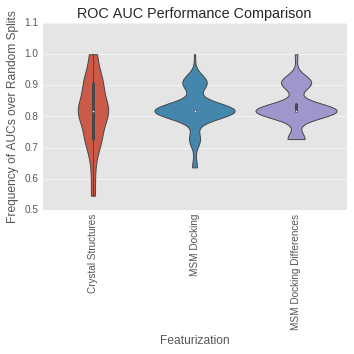

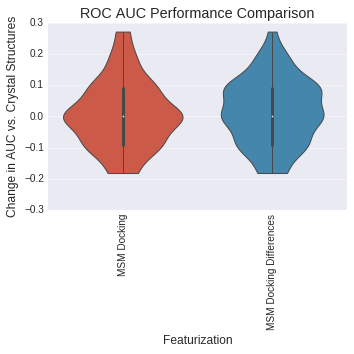

analyzing Recall:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Structures         0.910000          0.000000   
MSM Docking                0.977778          0.067778   
MSM Docking Differences    0.976667          0.066667   

                                         Sign Test 99% CI  
Crystal Structures                               (0, 0.0)  
MSM Docking              (0.365925226154, 0.615319187601)  
MSM Docking Differences  (0.375279625045, 0.624720374955)  


ValueError: list.remove(x): x not in list

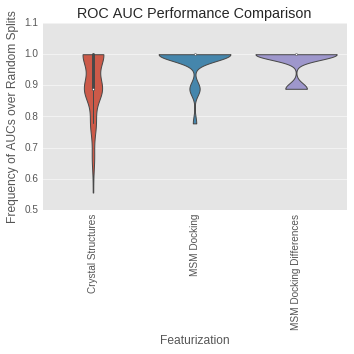

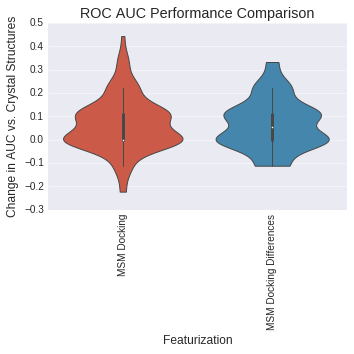

analyzing precision:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Structures         0.871910          0.000000   
MSM Docking                0.835232         -0.036677   
MSM Docking Differences    0.843929         -0.027981   

                                         Sign Test 99% CI  
Crystal Structures                               (0, 0.0)  
MSM Docking              (0.172648341273, 0.395973175076)  
MSM Docking Differences  (0.239991939807, 0.478674266508)  


ValueError: list.remove(x): x not in list

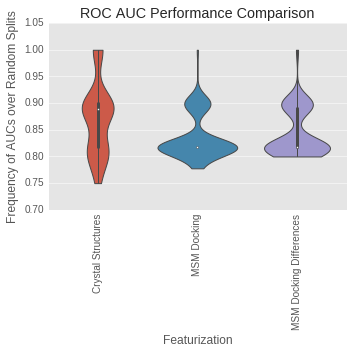

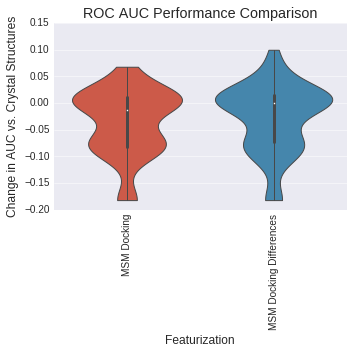

analyzing fdr:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Structures         0.128090          0.000000   
MSM Docking                0.164768          0.036677   
MSM Docking Differences    0.156071          0.027981   

                                         Sign Test 99% CI  
Crystal Structures                               (0, 0.0)  
MSM Docking              (0.384680812399, 0.634074773846)  
MSM Docking Differences   (0.32897683787, 0.577245230902)  


ValueError: list.remove(x): x not in list

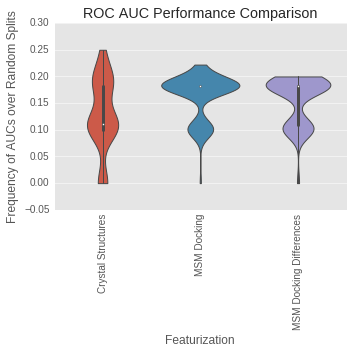

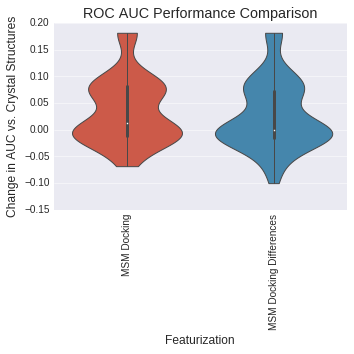

analyzing Recall:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Structures         0.910000          0.000000   
MSM Docking                0.977778          0.067778   
MSM Docking Differences    0.976667          0.066667   

                                         Sign Test 99% CI  
Crystal Structures                               (0, 0.0)  
MSM Docking              (0.365925226154, 0.615319187601)  
MSM Docking Differences  (0.375279625045, 0.624720374955)  


ValueError: list.remove(x): x not in list

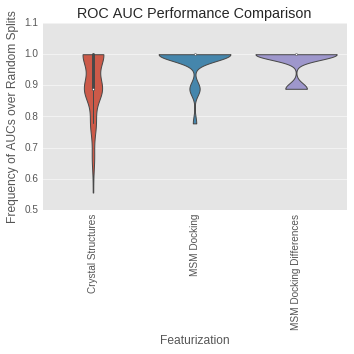

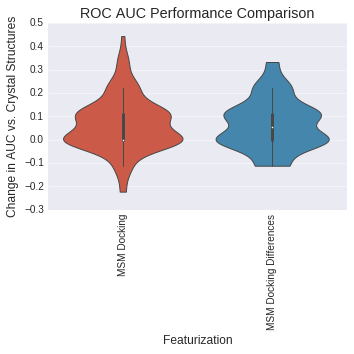

analyzing precision:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Structures         0.871910          0.000000   
MSM Docking                0.835232         -0.036677   
MSM Docking Differences    0.843929         -0.027981   

                                         Sign Test 99% CI  
Crystal Structures                               (0, 0.0)  
MSM Docking              (0.172648341273, 0.395973175076)  
MSM Docking Differences  (0.239991939807, 0.478674266508)  


ValueError: list.remove(x): x not in list

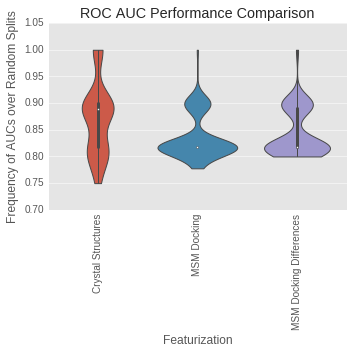

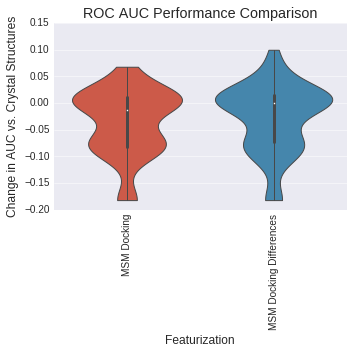

analyzing fdr:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Structures         0.128090          0.000000   
MSM Docking                0.164768          0.036677   
MSM Docking Differences    0.156071          0.027981   

                                         Sign Test 99% CI  
Crystal Structures                               (0, 0.0)  
MSM Docking              (0.384680812399, 0.634074773846)  
MSM Docking Differences   (0.32897683787, 0.577245230902)  


ValueError: list.remove(x): x not in list

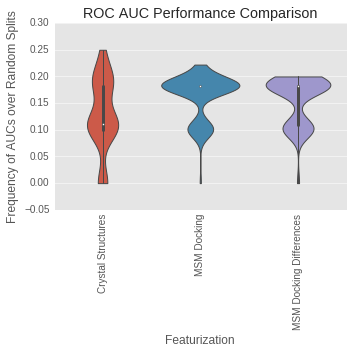

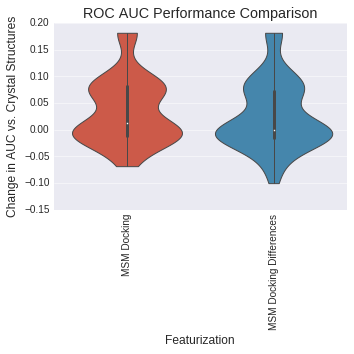

analyzing class B ROC AUC:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Structures         0.691667          0.000000   
MSM Docking                0.759167          0.067500   
MSM Docking Differences    0.757778          0.066111   

                                         Sign Test 99% CI  
Crystal Structures                               (0, 0.0)  
MSM Docking              (0.413165633404, 0.661856711579)  
MSM Docking Differences  (0.394128814565, 0.643382357926)  


ValueError: list.remove(x): x not in list

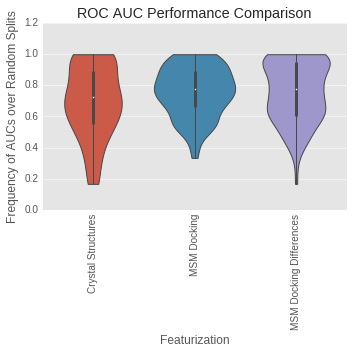

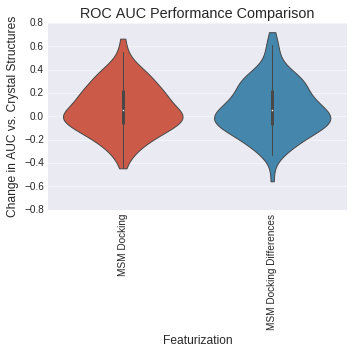

analyzing ROC AUC:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Structures         0.691667          0.000000   
MSM Docking                0.759167          0.067500   
MSM Docking Differences    0.757778          0.066111   

                                         Sign Test 99% CI  
Crystal Structures                               (0, 0.0)  
MSM Docking              (0.413165633404, 0.661856711579)  
MSM Docking Differences  (0.384680812399, 0.634074773846)  


ValueError: list.remove(x): x not in list

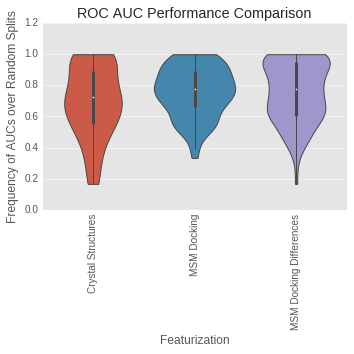

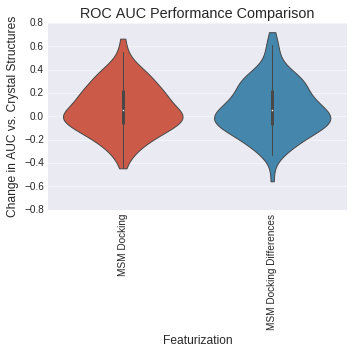

analyzing BedROC
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Structures         0.929606          0.000000   
MSM Docking                0.999145          0.069539   
MSM Docking Differences    0.953296          0.023690   

                                         Sign Test 99% CI  
Crystal Structures                               (0, 0.0)  
MSM Docking               (0.422754769098, 0.67102316213)  
MSM Docking Differences  (0.375279625045, 0.624720374955)  


ValueError: list.remove(x): x not in list

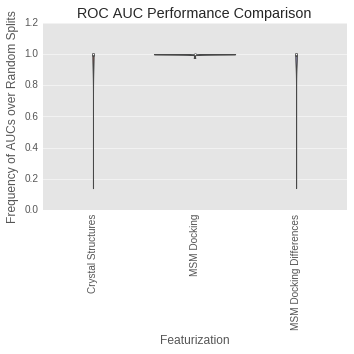

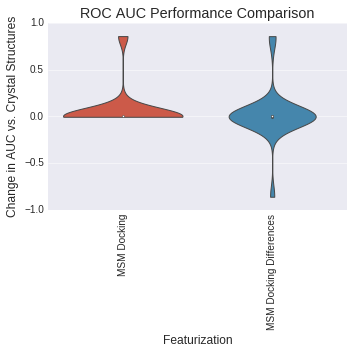

analyzing LogAUC
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Structures         0.065000          0.000000   
MSM Docking                0.068289          0.003289   
MSM Docking Differences    0.066227          0.001226   

                                         Sign Test 99% CI  
Crystal Structures                               (0, 0.0)  
MSM Docking              (0.257386290078, 0.498791088728)  
MSM Docking Differences  (0.257386290078, 0.498791088728)  


ValueError: list.remove(x): x not in list

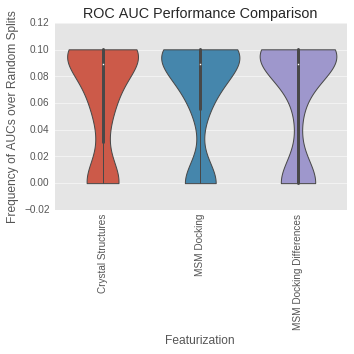

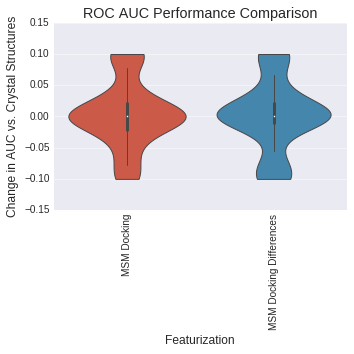

(3,)
(1, 3)


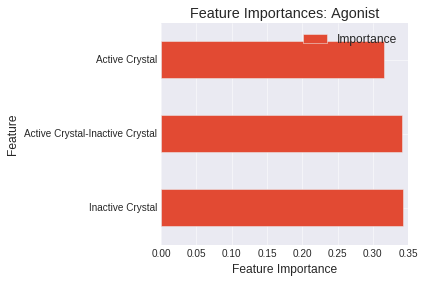

(54,)
(1, 54)


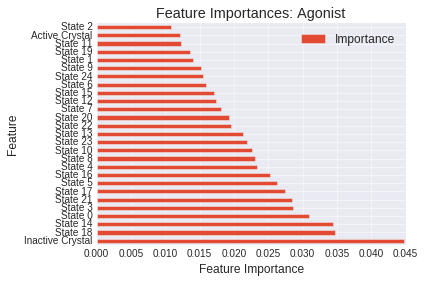

(403,)
(1, 403)


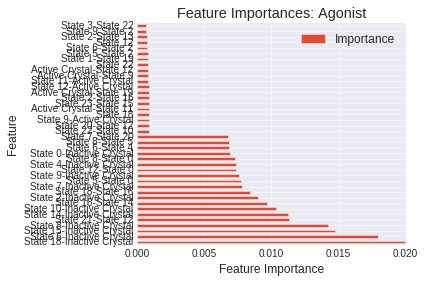

In [78]:
#Normalize False, axis0 True, RFR; fentanyl split
importance_dfs = analyze_multiclass_experiment(results_dict[save_name], 
                                                                feature_names,
                                                                [f.columns.values.tolist() for f in features], ligand_df.index.values, analysis_dir,
                                                                ["Antagonist", "Agonist"], 
                                                                #["Gs Inactive", "Gs Active"], 
                                                               #["Arr Inactive", "Arr Active"],
                                               np.hstack([X_df.loc[ligand_df.index].values]),
                                                               #["Gs Inactive", "Gs Partial Active", "Gs Full Active"], 
                                              remake=False, fxn=np.mean)

In [64]:
y_true = test_ligand_df["label"].sort("label", inplace=False, ascending=True)
y_pred = pd.DataFrame(results_dict[save_name]["MSM Docking"][0].predict_proba(new_df.loc[y_true.index.values.tolist()].values), index=y_true.index, columns=["antagonist", "agonist"])
auc = roc_auc_score(y_true.values.reshape((-1,1)), y_pred.values[:,1])
print(auc)
#roc_df = pd.DataFrame(rocs, columns=["aucs"], index=new_df.columns.values).sort("aucs", inplace=False)
#roc_df

0.654320987654


In [65]:
y_true = test_ligand_df["label"].sort("label", inplace=False, ascending=True)
y_pred = pd.DataFrame(results_dict[save_name]["Crystal Structures"][0].predict_proba(C_df.loc[y_true.index.values.tolist()].values), index=y_true.index, columns=["antagonist", "agonist"])
auc = roc_auc_score(y_true.values.reshape((-1,1)), y_pred.values[:,1])
print(auc)
#roc_df = pd.DataFrame(rocs, columns=["aucs"], index=new_df.columns.values).sort("aucs", inplace=False)
#roc_df

0.413580246914


In [ ]:
y_pred.sort("antagonist", inplace=False)

In [ ]:
model = results_dict[save_name]['MSM Docking'][0]
y_proba =model.predict_proba(new_df.values)
test_df = pd.DataFrame(y_proba, index=new_df.index, columns=["antagonist", "agonist"]).sort("agonist", ascending=False, inplace=False)
test_df.loc[[n for n in test_df.index if "compd11" in n]]

In [ ]:
pd.concat([y_pred, test_df.loc[[n for n in test_df.index if "compd11" in n and n != "compd11"]]], axis=0).sort("antagonist")

In [43]:
y_true = ligand_df["label"].sort("label", inplace=False, ascending=True)
rocs = [roc_auc_score(y_true.values.reshape((-1,1)), new_df.loc[y_true.index.values.tolist()][col].values) for col in new_df.columns]
roc_df = pd.DataFrame(rocs, columns=["aucs"], index=new_df.columns.values).sort("aucs", inplace=False)
roc_df

,aucs
State 17-State 10,0.230182
State 23-State 10,0.239636
State 13-State 10,0.253091
State 17-State 14,0.259455
State 5-State 10,0.262000
Inactive Crystal,0.262727
State 24-State 10,0.269636
State 23,0.270727
State 17-State 12,0.278727
State 16-State 10,0.283091


In [ ]:
from efficacy_scripts import *
smiles_list, compound_names, pc_smiles, pc_names = convert_sdfs_to_compounds(["/home/enf/htbc/sdfs/%s.sdf" %f for f in test_df.index.values], parallel=True, worker_pool=dview)
smiles_list = [s.strip() for s in smiles_list]
pc_smiles = [s.strip() for s in pc_smiles]
compound_names_df = pd.DataFrame(list(zip(smiles_list, compound_names, pc_smiles, pc_names)), index=test_df.index, columns=["smiles", "pubchem_name", "pubchem_smiles", "alternate_name"])
#for lig in p_bias_df.loc[[n for n in p_bias_df.index.values.tolist() if "_" == n[0]]].index.values[:100]:
#    for mol in pb.readfile("sdf", "/home/enf/htbc/sdfs/%s.sdf" %lig):
#        a = str(mol)
#        break
#    c = get_compounds(a, namespace='smiles')
    #print(c[0].synonyms)

In [ ]:
test_df[["pubchem_name", "smiles", "alternate_smiles", "alternate_name"]] = compound_names_df.loc[test_df.index][["pubchem_name", "smiles", "pubchem_smiles", "alternate_name"]]
bret_pred_df = test_df.loc[[n for n in test_df.index.values if n in common_ligands]]
bret_pred_df["label"] = 0.
bret_pred_df["label"].loc[common_ligands] = y
from rdkit.ML.Scoring.Scoring import CalcAUC
CalcAUC(bret_pred_df.values[:,(0,1)], col=0)#, alpha=10)

In [ ]:
test_df.loc[[n for n in test_df.index.values if "compd0" in n or "compd11" in n]].sort("class B", ascending=False,inplace=False).iloc[:]